# ** Data Wrangling with MongoDB**#
###### by Rajeswari Shanmugam

## Project Summary <a name="top"></a>
Name: Rajeswari Shanmugam

**Map area:**
+ Location: Chennai, South India
- <a href=http://wiki.openstreetmap.org/wiki/Chennai>Open Street Map of Chennai</a> 
http://www.openstreetmap.org/#map=13/13.0900/80.2700

Objective: Audit, clean the OSM dataset, convert from XML to JSON format and analyze insight within the data.


<hr>

<h2><a name="audit"></a> **1. Data Audit**</h2>

In [48]:
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
import collections
import pymongo

In [49]:
import os
chennai_data = "C:\\temp\\python\\chennai.osm"

> I parse Chennai OSM dataset downloaded to my temp directory on computer  with ElementTree and count the number of unique element types to get an overall understanding of the data by using count_tags function.

In [55]:
#Parse through the file with ElementTree and count the number of unique element types to understand overall structure.
def count_tags(filename):
        tags = {}
        for event, elem in ET.iterparse(filename):
            if elem.tag in tags: 
                tags[elem.tag] += 1
            else:
                tags[elem.tag] = 1
        return tags
chennai_tags = count_tags(chennai_data)
pprint.pprint(chennai_tags)

{'bounds': 1,
 'member': 864,
 'nd': 525604,
 'node': 424009,
 'osm': 1,
 'relation': 291,
 'tag': 115707,
 'way': 96484}


> For the following function: key_type & process_map. We check the "k"
value for each "<tag>" and see if they can be valid keys as well as see if there are any other potential problems.
As we saw in the quiz earlier, we would like to change the data
model and expand the "addr:street" type of keys to a dictionary like this:
{"address": {"street": "Some value"}}
So, we have to see if we have such tags, and if we have any tags with
problematic characters.

> For the function 'key_type', we have a count of each of
three tag categories in a dictionary:
  "lower", for tags that contain only lowercase letters and are valid,
  "lower_colon", for otherwise valid tags with a colon in their names,
  "problemchars", for tags with problematic characters, and so on.


In [58]:
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
        for tag in element.iter('tag'):
            k = tag.get('k')
            if lower.search(k):
                keys['lower'] += 1
            elif lower_colon.search(k):
                keys['lower_colon'] += 1
            elif problemchars.search(k):
                keys['problemchars'] += 1
            else:
                keys['other'] += 1
    return keys


def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

chennai_keys = process_map(chennai_data)
pprint.pprint(chennai_keys)

{'lower': 112471, 'lower_colon': 2818, 'other': 417, 'problemchars': 1}


> Below we check the file for the list of Unique user count who have contributed to this map online. We see 569 unique users have contributed to this map.



In [59]:
#people invovlved in the map editing.
def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        for e in element:
            if 'uid' in e.attrib:
                users.add(e.attrib['uid'])
    return users
users = process_map(chennai_data)
len(users)

569

<hr>

[<div align="center">Back to top</div>](#top)

<h2><a name="problems"></a> **2. Problem encountered**</h2>

<h3><a name="street"></a> **2.1 Street address abbreviation **</h3>

>  The main problem we encountered in this dataset come from the street name abbreviation inconsistency. In this following code, we build the regex matching the last element in the string, where usually the street type is based. Then we come up with a list of mapping that need not to be cleaned. For example in Chennai many streets are named Salai in the native language meaning Road. We find occurances of these native terms and convert them to meaningful interpretations.  

In [60]:
from collections import defaultdict

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Avenue", "Boulevard", "Commons", "Court", "Drive", "Lane", "Parkway", 
                         "Place", "Road", "Square", "Street", "Trail"]

mapping = {'Ave'  : 'Avenue',
           'Blvd' : 'Boulevard',
           'Dr'   : 'Drive',
           'Ln'   : 'Lane',
           'Pkwy' : 'Parkway',
           'Rd'   : 'Road',
           'Rd.'   : 'Road',
           'St'   : 'Street',
           'st'   : 'Street',
           'street' :"Street",
           'Salai': 'Road',
           'salai': 'Road',
           'Ct'   : "Court",
           'Cir'  : "Circle",
           'Cr'   : "Court",
           'ave'  : 'Avenue',
           'Hwg'  : 'Highway',
           'Hwy'  : 'Highway',
           'Sq'   : "Square"}



> + audit_street_type function will search the input string for the regex. If there is a match and it is not within the "expected" list, add the match as a key and add the string to the set.
+ is_street_name function looks at the attribute k if k="address:street" 
+ audit function will return the list that match previous two functions. After that, we would do a pretty print the output of the audit. With the list of all the abbreviated street types we can understand and fill-up our "mapping" dictionary as a preparation to convert these street name into meaningful form.


In [63]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    osm_file = open(osmfile, "r",encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])

    return street_types


In [64]:
chennai_street_types = audit(chennai_data)

> We then take a brief look at the unclean street name using pretty print below 

In [65]:
pprint.pprint(dict(chennai_street_types))

{'600042': {'Baby Nagar, Velachery, Chennai, Tamil Nadu 600042'},
 'Adambakkam': {'City Link Road, N.G.O. Colony, Ganesh Nagar, Adambakkam'},
 'Adyar': {'11th Cross Street, Shastri Nagar, Adyar',
           '1st Canal Cross Road, Gandhi Nagar, Adyar, Gandhi Nagar, Adyar',
           '2nd Avenue, Indira Nagar, Adyar',
           '2nd Avenue, Indira Nagar, Adyar, Chennai - 600, 020, Indira Nagar, '
           'Adyar',
           '4th Main Road, Gandhi Nagar, Adyar',
           'Gandhi Mandapam, Sardar Patel Road, Adyar',
           'Indira Nagar 1st Main Rd, Indira Nagar, Adyar',
           'Mahatma Gandhi Rd, Subramaniam Colony, Adyar'},
 'Adyar,': {'4th Main Road, Kasthuriba Nagar, Adyar, Kasturba Nagar, Adyar,'},
 'Alwarpet': {'Alwarpet', 'Kavingar Barathidasan Road, Alwarpet'},
 'Ave': {'14th Ave',
         '8th Ave',
         'Alumni Ave',
         'Hostel Ave',
         'Indira Nagar 1st Ave'},
 'Bridge': {'Maduvankarai Bridge'},
 'Chennai': {'3rd St, Ragavan Colony, Mettuppalayam,

> This last function update_name is the last step of the process, which take the old name and update them with a better name

In [66]:
def update_name(name, mapping, regex):
    m = regex.search(name)
    if m:
        street_type = m.group()
        if street_type in mapping:
            name = re.sub(regex, mapping[street_type], name)

    return name

for street_type, ways in chennai_street_types.items():
    for name in ways:
        better_name = update_name(name, mapping, street_type_re)
        print (name, "=>", better_name)

Mahatma Gandhi Rd => Mahatma Gandhi Road
Ramapuram Main Rd => Ramapuram Main Road
Kasturibai Nagar 1st Main Rd => Kasturibai Nagar 1st Main Road
Kodambakkam Rd => Kodambakkam Road
80 Feet Rd => 80 Feet Road
Valluvar Rd => Valluvar Road
Rangarajapuram Main Rd => Rangarajapuram Main Road
Thanikachalam Rd => Thanikachalam Road
Arya Gowda Rd => Arya Gowda Road
Kalakshethra Rd => Kalakshethra Road
LIC Colony Main Rd => LIC Colony Main Road
Arcot Rd => Arcot Road
Jawaharlal Nehru Rd => Jawaharlal Nehru Road
Viswanathapuram Main Rd => Viswanathapuram Main Road
sivaraman st => sivaraman Street
kalasathamman koil st => kalasathamman koil Street
Babu rajendra prasath st => Babu rajendra prasath Street
Parthasarathy St, Arulayiammanpet, Thiru Vi Ka Industrial Estate, Guindy => Parthasarathy St, Arulayiammanpet, Thiru Vi Ka Industrial Estate, Guindy
Defence Officers Colony Nandambakkam Extension Guindy => Defence Officers Colony Nandambakkam Extension Guindy
Five furlong road, Maduvankarai, Guindy

<hr>

[<div align="center">Back to top</div>](#top)

##### Preparing for MongoDB by converting XML to JSON

> In order to transform the data from XML to JSON, we need to follow these rules:
+ Process only 2 types of top level tags: "node" and "way"
+ All attributes of "node" and "way" should be turned into regular key/value pairs, except: attributes in the CREATED array should be added under a key "created", attributes for latitude and longitude should be added to a "pos" array, for use in geospacial indexing. Make sure the values inside "pos" array are floats and not strings. 
+ If second level tag "k" value contains problematic characters, it should be ignored
+ If second level tag "k" value starts with "addr:", it should be added to a dictionary "address"
+ If second level tag "k" value does not start with "addr:", but contains ":", you can process it
  same as any other tag.
+ If there is a second ":" that separates the type/direction of a street,
  the tag should be ignored

> After all the cleaning and data transformation are done, we would use last function process_map and convert the file from XML into JSON format

In [ ]:
import re
import codecs
import json

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
address_regex = re.compile(r'^addr\:')
street_regex = re.compile(r'^street')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]


def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way" :
        # YOUR CODE HERE
        node['type'] = element.tag
        # initialize empty address
        address = {}
        # parsing through attributes
        for a in element.attrib:
            if a in CREATED:
                if 'created' not in node:
                    node['created'] = {}
                node['created'][a] = element.get(a)
            elif a in ['lat', 'lon']:
                continue
            else:
                node[a] = element.get(a)
        # populate position
        if 'lat' in element.attrib and 'lon' in element.attrib:
            node['pos'] = [float(element.get('lat')), float(element.get('lon'))]

        # parse second-level tags for nodes
        for e in element:
            # parse second-level tags for ways and populate `node_refs`
            if e.tag == 'nd':
                if 'node_refs' not in node:
                    node['node_refs'] = []
                if 'ref' in e.attrib:
                    node['node_refs'].append(e.get('ref'))

            # throw out not-tag elements and elements without `k` or `v`
            if e.tag != 'tag' or 'k' not in e.attrib or 'v' not in e.attrib:
                continue
            key = e.get('k')
            val = e.get('v')

            # skip problematic characters
            if problemchars.search(key):
                continue

            # parse address k-v pairs
            elif address_regex.search(key):
                key = key.replace('addr:', '')
                address[key] = val

            # catch-all
            else:
                node[key] = val
        # compile address
        if len(address) > 0:
            node['address'] = {}
            street_full = None
            street_dict = {}
            street_format = ['prefix', 'name', 'type']
            # parse through address objects
            for key in address:
                val = address[key]
                if street_regex.search(key):
                    if key == 'street':
                        street_full = val
                    elif 'street:' in key:
                        street_dict[key.replace('street:', '')] = val
                else:
                    node['address'][key] = val
            # assign street_full or fallback to compile street dict
            if street_full:
                node['address']['street'] = street_full
            elif len(street_dict) > 0:
                node['address']['street'] = ' '.join([street_dict[key] for key in street_format])
        return node
    else:
        return None


def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data
process_map(chennai_data)

<hr>

[<div align="center">Back to top</div>](#top)

<h2><a name="data_overview"></a> **3. Data Analysis with MongoDB**</h2>

In [10]:
from pymongo import MongoClient
db_name = 'udacity'
client = MongoClient('localhost', 27017)
db = client['udacity']
collection = db['output']
print(collection.find_one())

print(len(collection.distinct('created.user')))

print ("Number of nodes:",collection.find({'type':'node'}).count())
print ("Number of ways:",collection.find({'type':'way'}).count())


{'_id': ObjectId('59d136d0c8d16b047ca61442'), 'type': 'node', 'id': '249797854', 'created': {'version': '9', 'timestamp': '2015-08-03T05:33:54Z', 'changeset': '33060572', 'uid': '2897465', 'user': 'maheshrkm'}, 'pos': [13.0353488, 80.2494237]}
563
Number of nodes: 424009
Number of ways: 96470


In [11]:
result = collection.aggregate( [
                                        { "$group" : {"_id" : "$created.user",
                                        "count" : { "$sum" : 1} } },
                                        { "$sort" : {"count" : -1} },
                                        { "$limit" : 50 } ] )


In [12]:

print(list(result))

[{'_id': 'maheshrkm', 'count': 74658}, {'_id': 'praveeng', 'count': 47532}, {'_id': 'rajureddyvudem', 'count': 36385}, {'_id': 'vamshikrishna', 'count': 35910}, {'_id': 'jasvinderkaur', 'count': 31714}, {'_id': 'Rahuldhanraj', 'count': 24394}, {'_id': 'PlaneMad', 'count': 20992}, {'_id': 'harishvarma', 'count': 19382}, {'_id': 'venkatkotha', 'count': 19103}, {'_id': 'masthanvali', 'count': 17541}, {'_id': 'saikumard', 'count': 15438}, {'_id': 'anushap', 'count': 14983}, {'_id': 'shivajim', 'count': 14320}, {'_id': 'ravikumar1', 'count': 14255}, {'_id': 'vamshiN', 'count': 13179}, {'_id': 'sramesh', 'count': 12714}, {'_id': 'vraju', 'count': 10327}, {'_id': 'shiva05', 'count': 9236}, {'_id': 'premkumar', 'count': 8971}, {'_id': 'venkatesh10', 'count': 8881}, {'_id': 'Naresh08', 'count': 7872}, {'_id': 'anthony1', 'count': 7176}, {'_id': 'harisha', 'count': 6281}, {'_id': 'uday01', 'count': 5273}, {'_id': 'pavanvijjapu', 'count': 5132}, {'_id': 'subhashini', 'count': 4305}, {'_id': 'thri

#### Top Cusine Types in Chennai

In [16]:
# Top Cusine Types
cuisine = collection.aggregate([{"$match":{"amenity":{"$exists":1},
                                 "amenity":"restaurant",}},
                      {"$group":{"_id":{"Food":"$cuisine"},
                                 "count":{"$sum":1}}},
                      {"$project":{"_id":0,
                                  "Food":"$_id.Food",
                                  "Count":"$count"}},
                      {"$sort":{"Count":-1}},
                      {"$limit":6}])
print(list(cuisine))


[{'Food': None, 'Count': 109}, {'Food': 'regional', 'Count': 20}, {'Food': 'indian', 'Count': 15}, {'Food': 'chinese', 'Count': 5}, {'Food': 'vegetarian', 'Count': 4}, {'Food': 'north_indian', 'Count': 3}]


#### Top Buildings Types in Chennai

In [17]:
building = collection.aggregate([
       {'$match': {'building': { '$exists': 1}}},
        {'$group': {'_id': '$building',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}},
        {'$limit': 50}])
print(list(building))


[{'_id': 'yes', 'count': 85379}, {'_id': 'apartments', 'count': 104}, {'_id': 'commercial', 'count': 44}, {'_id': 'university', 'count': 41}, {'_id': 'house', 'count': 29}, {'_id': 'residential', 'count': 25}, {'_id': 'school', 'count': 20}, {'_id': 'train_station', 'count': 13}, {'_id': 'temple', 'count': 11}, {'_id': 'office', 'count': 11}, {'_id': 'concourse', 'count': 8}, {'_id': 'industrial', 'count': 7}, {'_id': 'church', 'count': 5}, {'_id': 'retail', 'count': 4}, {'_id': 'hospital', 'count': 3}, {'_id': 'no', 'count': 2}, {'_id': 'mosque', 'count': 2}, {'_id': 'hotel', 'count': 2}, {'_id': 'mall', 'count': 1}, {'_id': 'stable', 'count': 1}, {'_id': 'place_of_worship', 'count': 1}, {'_id': 'greenhouse', 'count': 1}, {'_id': 'supermarket', 'count': 1}, {'_id': 'public', 'count': 1}, {'_id': 'hut', 'count': 1}, {'_id': 'roof', 'count': 1}]


#### Train Stations in Chennai

In [18]:
train = collection.aggregate([
       {'$match': {'network': { '$exists': 1}}},
        {'$group': {'_id': '$network',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}},
        {'$limit': 10}])
print(list(train))



[{'_id': 'MRTS', 'count': 9}, {'_id': 'Blue Line', 'count': 5}, {'_id': 'Green Line', 'count': 3}]


#### Sample visualization using Matplotlib for the Metro Lines


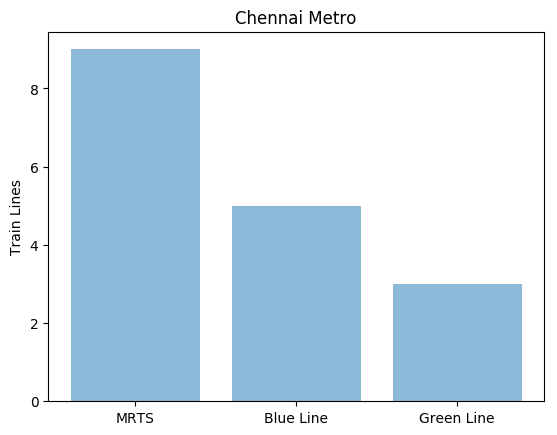

In [29]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('MRTS', 'Blue Line', 'Green Line')
y_pos = np.arange(len(objects))
performance = [9,5,3]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Train Lines')
plt.title('Chennai Metro')
 
plt.show()

[<div align="center">Back to top</div>](#top)

<h2><a name="conclusion"></a> **4. Conclusion**</h2>

> **_Ideas to improve data quality of OSM:_**

> During the entire process we found data quality to be utmost issue with OSM files. Given these are user generated content it would be nice if we had some checks and balances to ensure consitency of the data. The size of osm files also posed some issues and its a challange to parse and decode large files. A Carthographer inputs to review the OSM files after user generated content will be of great use. 

> **_Potential cost of the implementation:_**

> The potential cost of implementation is the maintaintance cost involved in keeping data consistency. Most of the user generated content online change very often and keeping them current for the relevent data analysis is a challange.